# Fashion MNIST 이미지 분류

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
import keras

In [2]:
tf.__version__

'2.19.0'

In [3]:
keras.__version__

'3.10.0'

In [4]:
print(keras.config.backend())           # keras 라이브러리에서 신경망 계산을 할때 필요한 라이브러리.

tensorflow


In [5]:
print(tf.config.list_physical_devices())            # CPU/GPU/TPU 사용 여부 확인

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Keras 라이브러리는 GPU 연산을 직접 수행하지 않음. 대신에 GPU 연산을 수행하는 다른 딥러닝 라이브러리를 백엔드(backend)로 활용함.

*   Keras에서 사용할 수 있는 백엔드 종류.
    *   TensorFlow - Google에서 만든 텐서(Tensor) 연산을 빠르게 수행하기 위한 라이브러리.
    *   PyTorch - Meta(페이스북)에서 만든 딥러닝 라이브러리 -> 리눅스 재단으로 오픈소스로 공개.
*   Keras
    *   여러가지 백엔드를 사용해서 신경망을 쉽게 만들고 사용할 수 있도록 만든 고급 라이브러리.
    *   2.3.1 버전 이후부터는 TensorFlow만 단일 백엔드로 사용하도록 기능 변경.
    *   3.0 버전부터 다시 멀테 백엔드 정책으로 바뀜.

# Fashion MNIST 데이터 셋

10가지 패션 아이템으로 이루어진 60000개 훈련 셋/ 레이블. 10000개 테스트 셋/ 레이블.

In [6]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# (훈련 셋, 훈련 레이블), (테스트 셋, 테스트 레이블)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
X_train.shape           # (n_samples, image_width, image_height)

(60000, 28, 28)

In [8]:
y_train.shape

(60000,)

In [9]:
np.unique(y_train, return_counts= True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [10]:
X_test.shape

(10000, 28, 28)

In [11]:
np.unique(y_test, return_counts= True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

훈련셋. 테스트셋 모두 각 클래스의 샘플들이 동일한 개수로 만들어져 있음.

데이터셋의 이미지를 시각화해보세요

In [12]:
def plot_fashion_mnist(arr, ncols= 10):
    # arr: (samples, wdith, height) shape의 3차원 배열
    # ncols: subplot axis의 컬럼 개수.
    n = len(arr)        # 출력할 이미지 개수
    nrows = int(np.ceil(n/ ncols))      # subplot axis 행 개수
    fig, ax = plt.subplots(nrows, ncols, figsize= (ncols, nrows))
    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j         # arr에서 선택할 이미지 인덱스.
            if nrows == 1 or ncols == 1:
                if idx < n:
                    ax[idx].imshow(arr[idx], cmap = plt.cm.binary)
                ax[idx].axis('off')
            else:
                if idx < n:
                    ax[i,j].imshow(arr[idx], cmap= plt.cm.binary)
                ax[i,j].axis('off')

    plt.show()



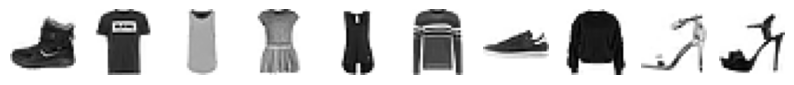

In [13]:
plot_fashion_mnist(X_train[:10])

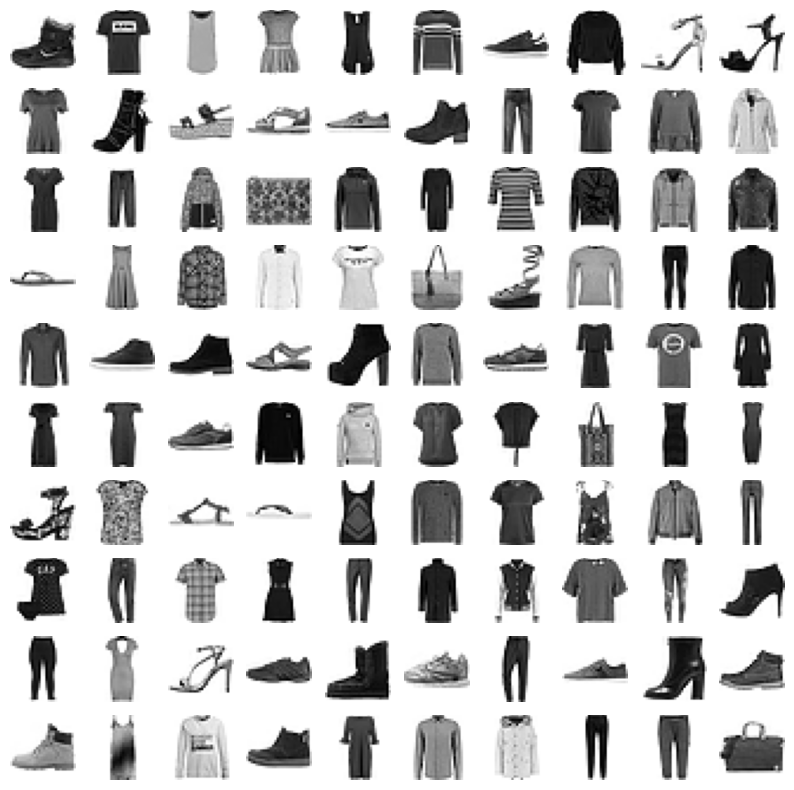

In [14]:
plot_fashion_mnist(X_train[:100])

# 훈련 셋/ 레이블을 훈련셋과 검증 셋으로 분리

In [15]:
train_data, val_data, train_target, val_target = \
        train_test_split(X_train, y_train, random_state= 42, test_size= 0.2, stratify= y_train)

In [16]:
print(train_data.shape)
print(train_target.shape)
print(np.unique(train_target, return_counts= True))

(48000, 28, 28)
(48000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800]))


In [17]:
print(val_data.shape)
print(val_target.shape)
print(np.unique(val_target, return_counts= True))

(12000, 28, 28)
(12000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]))


# SGD Classifier

In [18]:
train_data[0]           #> 각 픽셀의 값들이 0(white) ~ 225(black)

array([[  0,   0,   0,   0,   1,   1,   0,   0,   0,  25,  55,   0,   0,
          0,   0,   0,   0,  43,  24,   0,   0,   0,   1,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   1,   1,   0,  25, 147, 189, 181,  96,  51,
         49,  55,  37,  76, 217, 172, 125,  20,   0,   2,   1,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   3,   0,  82, 206, 202, 190, 178, 188, 239,
        152,  99, 199, 201, 162, 176, 192, 185,  71,   0,   2,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0, 202, 196, 181, 188, 183, 169, 179,
        160, 107, 198, 166, 167, 178, 170, 183, 166,   0,   0,   1,   0,
          0,   0],
       [  0,   0,   0,   1,   0,  48, 216, 184, 185, 185, 190, 175, 164,
        188, 198, 188, 157, 183, 176, 171, 167, 175,  26,   0,   2,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  90, 224, 183, 185, 184, 183, 190, 164,
        169, 193, 158, 170, 174, 176, 175, 165, 180,  62,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 123, 228, 184, 180, 183, 178, 183, 172,
        172, 172, 161, 179, 170, 174, 175, 165, 181, 106,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 156, 229, 188, 175, 178, 175, 175, 190,
        157, 157, 180, 169, 169, 172, 171, 161, 179, 143,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 181, 228, 190, 174, 174, 176, 175, 197,
        167, 167, 183, 166, 169, 171, 170, 162, 175, 172,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   6, 175, 221, 192, 170, 174, 176, 175, 193,
        176, 172, 175, 167, 169, 169, 167, 160, 169, 196,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  23, 184, 216, 206, 164, 175, 176, 175, 192,
        178, 175, 174, 167, 166, 169, 169, 165, 169, 175,   6,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  53, 189, 208, 219, 161, 176, 176, 175, 190,
        181, 178, 172, 169, 165, 170, 169, 166, 167, 183,  26,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  84, 194, 207, 216, 157, 176, 175, 176, 193,
        183, 180, 172, 167, 167, 166, 170, 165, 167, 185,  61,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 114, 193, 211, 207, 157, 175, 175, 176, 196,
        183, 181, 172, 166, 166, 165, 170, 164, 169, 187,  88,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 155, 192, 219, 194, 161, 172, 178, 176, 197,
        185, 181, 169, 166, 165, 165, 171, 164, 171, 184, 108,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 181, 192, 225, 185, 162, 172, 179, 176, 199,
        185, 183, 169, 166, 164, 164, 172, 161, 170, 184, 135,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 210, 189, 233, 180, 161, 171, 179, 179, 201,
        185, 190, 166, 166, 164, 164, 176, 158, 171, 183, 155,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 229, 184, 234, 176, 164, 169, 180, 183, 198,
        185, 193, 166, 167, 164, 165, 179, 157, 176, 179, 174,   0,   0,
          0,   0],
       [  0,   0,   0,   2, 237, 183, 237, 171, 166, 167, 178, 188, 196,
        187, 196, 164, 166, 165, 166, 179, 157, 178, 176, 185,   2,   0,
          0,   0],
       [  0,   0,   0,  24, 246, 184, 255, 172, 166, 169, 180, 192, 196,
        189, 201, 161, 164, 165, 165, 181, 161, 181, 176, 189,  17,   0,
          0,   0],
       [  0,   0,   0,  52, 247, 187, 238, 166, 170, 170, 180, 198, 193,
        189, 207, 160, 165, 165, 164, 180, 162, 187, 175, 192,  52,   0,
          0,   0],
       [  0,   0,   0,  82, 215, 192, 239, 158, 169, 174, 179, 207, 189,
        187, 213, 160, 167, 166, 165, 181, 169, 190, 170, 192,  73,   0,
          0,   0],
       [  0,   0,   0, 102, 212, 201, 212, 166, 169, 171, 179, 217, 189,
        187, 217, 157, 170, 167, 166, 178, 171, 196, 169, 171,  84,   0,
          0,   0],
       [  0,   0,   0, 166, 211, 213, 193, 164, 170, 170, 180, 226, 181,
        187, 228, 157, 167, 167, 158, 188, 196, 128, 170, 179, 128,   0,
          0,   0],
       [  0,   0,   0,  35,  92, 129, 19

In [19]:
# 훈련 셋의 픽셀 값을 0 ~ 1 사이의 값으로 스케일링   -> 확률적 경사 하강법 성능을 높이기 위해서.
train_data_scaled = train_data / 255.0

In [20]:
train_data_scaled.shape

(48000, 28, 28)

In [21]:
sgd = SGDClassifier(loss = 'log_loss', random_state= 42, n_jobs= -1)

In [22]:
sgd.fit(X= train_data_scaled.reshape(48000, -1), y= train_target)

SGDClassifier(loss='log_loss', n_jobs=-1, random_state=42)

In [23]:
sgd.intercept_          #> shape: (10,)

array([ -1.54024535,  -4.97085256,  -2.45411884,  -1.5496291 ,
        -4.94592029,   3.66151889,  -1.47955462,  -1.90241534,
        -4.40078057, -25.19876253])

In [24]:
sgd.coef_.shape         #> (10, 784)

(10, 784)

In [25]:
predict_probas = sgd.predict_proba(X= train_data_scaled.reshape(48000, -1))

In [26]:
predict_probas.shape

(48000, 10)

In [27]:
predict_probas[:5]

array([[1.20888251e-02, 1.05549631e-05, 2.30094285e-01, 3.41231387e-03,
        4.86284532e-02, 3.96063160e-10, 6.91742929e-01, 1.54454383e-17,
        1.40226378e-02, 1.05805064e-16],
       [7.53889861e-01, 1.20438290e-04, 4.89841116e-05, 2.88644150e-04,
        7.52168267e-02, 4.15812599e-17, 1.69806662e-01, 2.22627871e-15,
        6.28584469e-04, 3.41774283e-15],
       [2.89450403e-03, 2.51542365e-04, 1.32250305e-04, 9.78121334e-01,
        2.43557068e-04, 8.15414752e-12, 1.83430550e-02, 1.32044303e-06,
        1.24368179e-05, 1.15226778e-10],
       [1.87927047e-02, 1.53865511e-02, 4.75084700e-03, 9.59873842e-01,
        2.15421676e-04, 2.30937550e-07, 4.85837345e-04, 7.79498173e-08,
        4.94463323e-04, 2.39574997e-08],
       [9.71611164e-01, 8.55700455e-07, 2.35430174e-03, 2.77866962e-07,
        7.27359445e-06, 2.50343665e-19, 2.58251753e-02, 6.13245802e-16,
        2.00951140e-04, 2.02813751e-10]])

In [28]:
predicts = sgd.predict(X = train_data_scaled.reshape((48000, -1)))

In [29]:
predicts.shape          #> (48000,)

(48000,)

In [30]:
predicts[:5]

array([6, 0, 3, 3, 0], dtype=uint8)

In [31]:
accuracy_score(train_target, predicts)          # 훈련 셋 정확도

0.8518125

In [32]:
# 쉬는 시간에 검증셋 해보기
val_data[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  36,  25,   0,   0,   0,   0,  33,  98,  76,  79,
         46,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   4,  74,  86,  70,  33,   0,   0,  82,  89,  62,  86,
        100,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  47,  63,  79,  97, 127,  98,   3,  71, 124,  63,  74,
         87,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          1,   0,  43,  94, 100,  82,  90, 121, 129, 148, 157,  62,  78,
        105,   0],
       [  0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   4,  78, 137, 100,  95,  92, 125, 145,  76,  68,
        103,   0],
       [  0,   0,   0,   0,   0,   1,   0,   3,   3,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  68, 138, 105, 108, 100, 113,  74,  62,
        113,  14],
       [  0,   1,   3,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   1,   0,   0,  60, 154, 108,  90, 122,  66,  60,
        111,  28],
       [  1,   0,   0,   0,   0,  39,  46,  84, 135,   0,   0,   0,   1,
          0,   0,   0,   0,   0,   0,   0,  11, 146, 173, 127,  62,  66,
         97,  35],
       [  0,   0,  23,   0,  30,  94,  36,  92, 255,   0,   0,   0,   0,
          0,   0,   3,  11,   1,   1,  12,   0,  52, 157,  58,  73,  62,
         98,  35],
       [ 52, 106,  44,  62,  14,   0,   0,  35, 194,  62,   7,  23,  33,
         39,  58,  87, 113, 116, 130, 176, 181, 202, 108,   4,  58,  57,
         97,  68],
       [ 65, 181, 173, 159, 154,  44,  78,  55, 114, 184, 173, 197, 204,
        211, 216, 218, 221, 227, 224, 204, 189, 211, 234,  12,  35,  30,
         82,  25],
       [  0,  38, 125, 164, 178, 113, 109, 114, 124, 194, 192, 184, 168,
        149, 145, 143, 148, 127, 133, 148, 157, 170, 178, 197, 189, 160,
        121,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   

In [33]:
val_data_scaled = val_data / 255.0

In [34]:
val_data_scaled.shape

(12000, 28, 28)

In [35]:
val_data_scaled_reshape = val_data_scaled.reshape(12000,-1)

In [36]:
val_data_scaled_reshape.shape

(12000, 784)

In [37]:
predict_probas = sgd.predict_proba(X= val_data_scaled_reshape)

In [38]:
predict_probas.shape

(12000, 10)

In [39]:
predict_probas[:5]

array([[3.08336014e-04, 2.33033961e-04, 3.93221670e-03, 2.31878065e-04,
        5.87500409e-04, 8.53162570e-01, 5.80615940e-03, 1.17882521e-01,
        1.78297582e-02, 2.60253766e-05],
       [5.59242139e-03, 1.12059451e-04, 1.21315367e-03, 1.60892554e-03,
        8.37951497e-01, 3.94471243e-12, 1.53401704e-01, 2.34952790e-16,
        1.20238316e-04, 3.61939427e-18],
       [1.29385944e-05, 3.06188183e-05, 8.30278310e-05, 1.93728005e-05,
        1.38490441e-04, 9.39022592e-01, 4.85974214e-05, 3.69733112e-02,
        2.36686861e-02, 2.36506250e-06],
       [2.26648003e-02, 4.38167583e-03, 2.47595034e-01, 5.21934735e-05,
        7.21103801e-01, 1.10933221e-12, 3.33905731e-03, 1.19312916e-14,
        8.63438018e-04, 5.16690287e-18],
       [1.82474058e-02, 9.61987365e-01, 4.82575507e-03, 1.87741908e-03,
        1.19680027e-02, 3.30075820e-11, 6.22056701e-04, 1.07417100e-06,
        4.70921205e-04, 1.39471687e-10]])

In [40]:
predicts = sgd.predict(X = val_data_scaled_reshape)

In [41]:
accuracy_score(val_target, predicts)

0.8468333333333333

# 신경망

입력층과 출력층만 갖는 신경망을 Keras 라이브러리를 사용해서 만들고 테스트

In [42]:
tr_data_scaled_flat = train_data_scaled.reshape((48000, -1))        #> shape: 948000, 784)
val_data_scaled_flat = val_data_scaled_reshape                      #> shape: (12000, 784)

In [43]:
tr_data_scaled_flat.shape

(48000, 784)

In [44]:
inputs = keras.layers.Input(shape= (784,))

In [45]:
dense = keras.layers.Dense(units= 10 , activation='softmax')

In [46]:
model = keras.Sequential(layers= [inputs, dense])

In [47]:
model.summary(0)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.compile(loss= keras.losses.sparse_categorical_crossentropy,
              metrics = [keras.metrics.sparse_categorical_accuracy])

In [49]:
model.fit(x= tr_data_scaled_flat, y = train_target, epochs= 10, verbose= 0)

In [50]:
model.weights

[<Variable path=sequential/dense/kernel, shape=(784, 10), dtype=float32, value=[[-0.02962859  0.01657696 -0.07479161 ... -0.05464986 -0.06900274
   -0.06113571]
  [ 0.06959858  0.00187368 -0.08019637 ...  0.08039209 -0.03893442
   -0.04242632]
  [-0.05689948 -0.01976088 -0.00642581 ...  0.00833104 -0.07428636
   -0.0160428 ]
  ...
  [-0.38756242 -0.18437564  0.17096598 ... -0.02644989 -0.7490869
   -0.17606384]
  [-0.32202142  0.03626212 -0.00218277 ... -0.1057841  -0.6282103
   -0.06012052]
  [ 0.00778421 -0.01101171  0.04300685 ...  0.05337134 -0.28647122
    0.07350089]]>,
 <Variable path=sequential/dense/bias, shape=(10,), dtype=float32, value=[ 0.3125978  -0.8142425  -0.20938046  0.54920226 -1.0509052   2.3596976
   0.3065522  -0.21568581 -0.60682386 -1.645074  ]>]

In [51]:
# 훈련 셋 평가
model.evaluate(x=tr_data_scaled_flat, y= train_target)              #> [loss(손실), accuracy(정확도)]

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4021 - sparse_categorical_accuracy: 0.8662


[0.4092780649662018, 0.8628958463668823]

In [52]:
# 검증 셋 평가
model.evaluate(x=val_data_scaled_flat, y= val_target)              #> [loss(손실), accuracy(정확도)]

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4241 - sparse_categorical_accuracy: 0.8525


[0.4195103347301483, 0.859499990940094]

In [53]:
tr_target_pred = model.predict(tr_data_scaled_flat)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [54]:
tr_target_pred.shape            #> (48000 이미지 샘플, 10개 확률)

(48000, 10)

In [55]:
tr_target_pred[:2]

array([[3.20965727e-03, 2.96941744e-06, 3.90712321e-01, 5.79632865e-03,
        3.37340795e-02, 9.29944344e-16, 5.64901054e-01, 1.50401166e-22,
        1.64361543e-03, 2.21165447e-22],
       [5.49260139e-01, 1.26489726e-06, 4.39912034e-03, 6.68031815e-03,
        1.15022035e-02, 1.14834640e-24, 4.28023756e-01, 2.25958465e-22,
        1.33203983e-04, 2.52312380e-23]], dtype=float32)

In [56]:
tr_target_pred_label = tr_target_pred.argmax(axis=1)            # 최댓값의 인덱스를 리턴.
print(tr_target_pred_label.shape)
print(tr_target_pred_label[:10])


(48000,)
[6 0 3 3 0 5 9 3 2 1]


In [57]:
accuracy_score(y_true= train_target, y_pred= tr_target_pred_label)

0.8628958333333333

# 활성화 함수(Activation Function)

## Sigmoid

$
\text{sigmoid}(x) = \dfrac{1}{1 + \exp(-x)}
$

In [58]:
xvals = np.arange(-5, 5, 0.0001)

In [59]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [60]:
yvals = sigmoid(xvals)

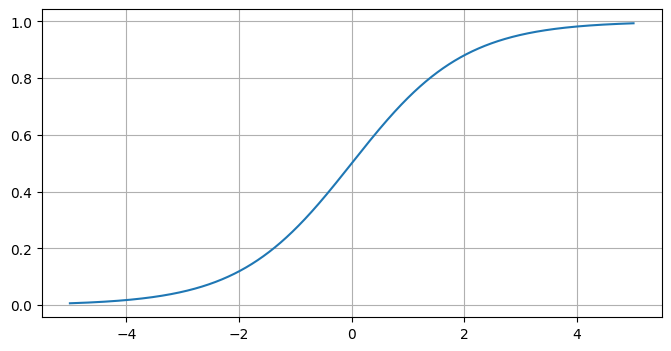

In [61]:
plt.figure(figsize= (8,4))
plt.plot(xvals, yvals)
plt.grid()
plt.show()

## Hyperbolic tangent

In [62]:
def plot_activation_fn(fn):
    xvals = np.arange(-5, 5, 0.0001)
    yvals = fn(xvals)
    plt.figure(figsize= (8,4))
    plt.plot(xvals, yvals)
    plt.grid()
    plt.show()

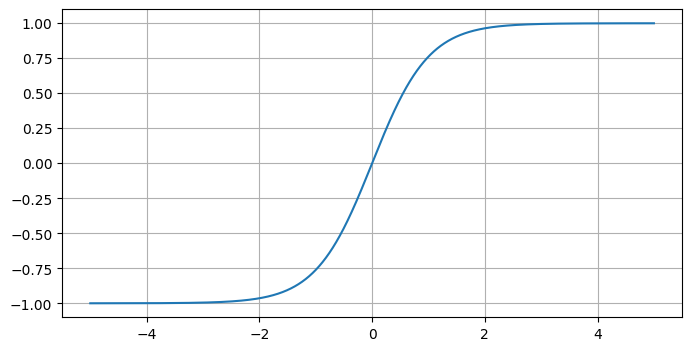

In [63]:
plot_activation_fn(np.tanh)

## ReLu(Rectified Linear Unit)

*   입력값이 양수이면 마치 활성화 함수가 없는 것처럼 입력값 그대로 출력으로 내보냄.
*   입력값이 음수이면 출력값을 0으로 만듦.
*   이미지 처리를 할 때 좋은 성능을 낸다고 알려져 있음.

$
\text{ReLU}(x) =
\begin{cases}
    x & \text{for } x \ge 0 \\
    0 & \text{for } x \lt 0
\end{cases}
$

In [64]:
def relu(x):
    return np.maximum(x, 0)         #> 둘중에 큰 값을 리턴


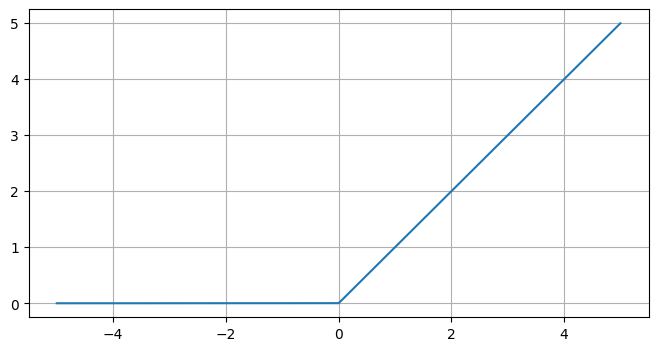

In [65]:
plot_activation_fn(relu)

## Leaky ReLU

$
\text{LeakyReLU}(x, \alpha) =
\begin{cases}
    x & \text{for } x \ge o \\
    \alpha x & \text{for } x \lt 0
\end{cases}
$

In [66]:
def leaky_relu(x, alpha= 0.1):
    # 0 <= alpha <= 1
    return np.maximum(x, alpha * x)

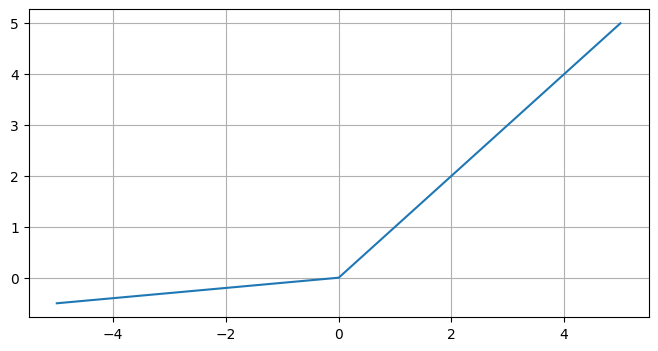

In [67]:
plot_activation_fn(leaky_relu)

## ELU(Exponential Linear Unit)

$
\text{ELU}(x, \alpha) =
\begin{cases}
    x & \text{for } x \ge 0 \\
    \alpha (\exp(x) - 1) & \text{for } x \lt 0

\end{cases}
$

In [68]:
def elu(arr, alpha= 1):
    # 0 <= alpha
    result = []
    for x in arr:
        if x >= 0:
            result.append(x)
        else:
            result.append(alpha * (np.exp(x) - 1))
    return np.array(result)


In [69]:
# 한줄짜리
def elu(x, alpha= 1):
    return np.where(x >= 0, x, alpha * (np.exp(x) -1))

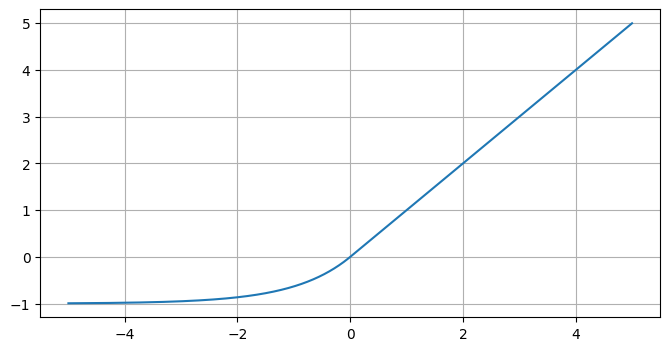

In [70]:
plot_activation_fn(elu)

은닉층에서의 활성화 함수 선택: ELU > LeakyReLu > ReLU > tanh > sigmoid

# ReLU를 활성화 함수로 사용하는 은닉층

In [71]:
model = keras.Sequential()

In [72]:
model.add(keras.Input(shape=(28,28)))           # 입력층

In [73]:
model.add(keras.layers.Flatten())               # (28,28)의 배열을  (784,) shape으로 변환

In [74]:
model.add(keras.layers.Dense(units= 100, activation= 'relu'))           # 100개의 unit을 갖는 ReLU를 활성화 함수로 사용하는 은닉층을 추가

In [75]:
# 출력층 -  다중 클래스 분류. 10개의 unit을 갖고 softmax를 활성화 함수로 사용하는 층.
model.add(keras.layers.Dense(units= 10, activation= 'softmax'))

In [76]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# 모델 컴파일
model.compile(loss= keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [78]:
# 모델 훈련
model.fit(x= train_data_scaled, y= train_target, epochs= 5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6870 - sparse_categorical_accuracy: 0.7634
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.4019 - sparse_categorical_accuracy: 0.8548
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3613 - sparse_categorical_accuracy: 0.8694
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3291 - sparse_categorical_accuracy: 0.8794
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3205 - sparse_categorical_accuracy: 0.8853


In [79]:
# 모델 평가 - 훈련 셋의 손실/정확도
model.evaluate(x= train_data_scaled, y=train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3172 - sparse_categorical_accuracy: 0.8835


[0.3196961581707001, 0.8823333382606506]

In [80]:
# 모델 평가 - 검증 셋의 손실/정확도
model.evaluate(x=val_data_scaled, y= val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3731 - sparse_categorical_accuracy: 0.8669


[0.3771861493587494, 0.8692499995231628]

# ELU를 활성화 함수로 사용하는 은닉층

In [81]:
model = keras.Sequential()

In [82]:
model.add(keras.Input(shape= (28,28)))

In [83]:
model.add(keras.layers.Flatten())

In [84]:
model.add(keras.layers.Dense(units= 100, activation= 'elu'))

In [85]:
model.add(keras.layers.Dense(units= 10, activation= 'softmax'))

In [86]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              metrics= [keras.metrics.sparse_categorical_accuracy])

In [88]:
model.fit(x= train_data_scaled, y = train_target, epochs= 5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6640 - sparse_categorical_accuracy: 0.7654
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4051 - sparse_categorical_accuracy: 0.8549
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3664 - sparse_categorical_accuracy: 0.8674
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3330 - sparse_categorical_accuracy: 0.8786
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3160 - sparse_categorical_accuracy: 0.8826


In [89]:
# 모델 평가 - 훈련 셋의 손실/정확도
model.evaluate(x= train_data_scaled, y=train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3079 - sparse_categorical_accuracy: 0.8860


[0.3119286000728607, 0.8854374885559082]

In [90]:
# 모델 평가 - 검증 셋의 손실/정확도
model.evaluate(x=val_data_scaled, y= val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3497 - sparse_categorical_accuracy: 0.8688


[0.3495467007160187, 0.8736666440963745]

# Optimizer

*   경사 하강법(Gradient Descent)
    *    손실 함수를 최소로 만드는 가중치들을 찾는 방법.

$
w_{next} = w_{init} - 학습률 \cdot 기울기
$

*    아주 큰 신경망인 경우는 모델 훈련을 통해서 찾아야 하는 모델 파라미터들의 개수가 매우 많음.
*   모델 파라미터들의 개수가 많을 수록 훈련 속도가 심각하게 느려질 수 있음.
*   훈련 속도를 높이는 방법:
    *   좋은 초기화 전략 사용하기
    *   좋은 활성화 함수 사용하기
    *   배치 정규화 사용하기
    *   사전 훈련된 네트워크(신경망)의 일부를 재사용.
    *   일반적인 경사 하강법 대신 더 빠른 옵티마이저를 사용하기.
*   확률적 경사 하강법(SGD)의 변종 옵티마이저
    *   학습률(learning_rate) 파라미터를 변경.
    *   모멘텀 최적화(momentum optimization): 모멘텀(momentum) 파라미터 값을 0보다 큰 값으로 변경.
    *   네스테로프 가속 경사(Nesterov Accelerated Gradient, NAG): nesterov 파라미터를 True로 설정.
*   적응형 학습률(adaptive learning rate): 학습할 때마다 학습률을 변화시킴.
    *   RMSprop(Root Mean Squared Propagation): Sequential 클래스의 compile 메서드의 optimizer 기본값.
    *   Adam(Adaptive Momentum Estimation): 모멘텀 최적화 + RMSprop
    *   Nadam: Adam + Nesterov
*   AdaGrad

## SGD optimizer

In [91]:
def create_model(layers= None):
    # layers: keras.layers 객체들의 배열/ 리스트.
    model = keras.Sequential()          # Sequential 모델 생성
    model.add(keras.Input(shape= (28, 28)))         # 입력층 추가
    model.add(keras.layers.Flatten())               # Flatten layer 추가
    model.add(keras.layers.Dense(units =100, activation= 'relu'))           # 첫번쨰 은닉층을 추가
    if layers:          # 아규먼트로 전달된 은닉층들이 있으면
        for layer in layers:
            model.add(layer)

    model.add(keras.layers.Dense(units=10, activation= 'softmax'))          # 출력층 추가

    return model


In [92]:
model = create_model()

In [93]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
# 옵티마이저: 학습률을 변경, 모멘텀 최적화, 네스테로프 가속 경사
op = keras.optimizers.SGD(learning_rate= 0.02, momentum = 0.1, nesterov= True)
model.compile(optimizer= op,
              loss= keras.losses.sparse_categorical_crossentropy,
              metrics= [keras.metrics.sparse_categorical_accuracy])

In [95]:
model.fit(x= train_data, y= train_target, epochs= 5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9254.5293 - sparse_categorical_accuracy: 0.0983
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.3025 - sparse_categorical_accuracy: 0.0984
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.3027 - sparse_categorical_accuracy: 0.0998
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.3028 - sparse_categorical_accuracy: 0.0979
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 2.3028 - sparse_categorical_accuracy: 0.0983


In [96]:
model.evaluate(x= train_data_scaled, y= train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.1015


[2.3026556968688965, 0.10000000149011612]

In [97]:
model.evaluate(x = val_data_scaled, y = val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3026 - sparse_categorical_accuracy: 0.0996


[2.3026540279388428, 0.10000000149011612]

## Adam optimizer

*   `learning_rate`파라미터: 학습률
*   `beta_1`, `beta_2` 파라미터: 모멘텀 최적화와 관련된 파라미터.
*   `epsilon` 파라미터: 적응형 학습률과 관련된 파라미터.

In [98]:
model = create_model()

In [99]:
model.compile(optimizer= keras.optimizers.Adam(),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [100]:
model.fit(x= train_data_scaled, y= train_target, epochs= 5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6815 - sparse_categorical_accuracy: 0.7628
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4110 - sparse_categorical_accuracy: 0.8550
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3613 - sparse_categorical_accuracy: 0.8696
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.3315 - sparse_categorical_accuracy: 0.8803
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3101 - sparse_categorical_accuracy: 0.8855


In [101]:
model.evaluate(x= train_data_scaled, y= train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2979 - sparse_categorical_accuracy: 0.8871


[0.30040159821510315, 0.8869374990463257]

In [102]:
model.evaluate(x= val_data_scaled, y = val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3428 - sparse_categorical_accuracy: 0.8728


[0.3422919809818268, 0.875333309173584]

# 모델 훈련

In [103]:
model = create_model()          # 은닉층 1개를 갖는 모델을 생성
model.compile(optimizer= keras.optimizers.RMSprop(),
              loss= keras.losses.sparse_categorical_crossentropy,
              metrics= [keras.metrics.sparse_categorical_accuracy])            # 모델 컴파일

In [104]:
result = model.fit(x= train_data_scaled, y= train_target, epochs= 5,
                   validation_data= [val_data_scaled, val_target])

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6755 - sparse_categorical_accuracy: 0.7672 - val_loss: 0.4280 - val_sparse_categorical_accuracy: 0.8460
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.4004 - sparse_categorical_accuracy: 0.8537 - val_loss: 0.3594 - val_sparse_categorical_accuracy: 0.8751
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3598 - sparse_categorical_accuracy: 0.8699 - val_loss: 0.3703 - val_sparse_categorical_accuracy: 0.8718
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3347 - sparse_categorical_accuracy: 0.8769 - val_loss: 0.3640 - val_sparse_categorical_accuracy: 0.8708
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3228 - sparse_categorical_accuracy: 0.8838 - val_loss: 0.3371 - val_sparse_categorical_accuracy: 0.8867


## History 객체

신경망 모델을 훈련(fit)시키는 과정(각각의 epoch)의 기록을 담고 있는 객체. fit 메서드의 리턴 값.

In [105]:
type(result)

keras.src.callbacks.history.History

In [106]:
hist =  result.history
# 각 epoch마다 훈련 셋 손실/정확도, 검증 셋 손실/정확도를 dict로 저장

In [107]:
hist.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [108]:
hist.items()

dict_items([('loss', [0.5317279100418091, 0.3955734372138977, 0.35865575075149536, 0.3369627594947815, 0.32187679409980774]), ('sparse_categorical_accuracy', [0.8127708435058594, 0.8568333387374878, 0.8705416917800903, 0.8767708539962769, 0.8846458196640015]), ('val_loss', [0.42796412110328674, 0.3593789339065552, 0.3703029453754425, 0.3640148937702179, 0.3370698094367981]), ('val_sparse_categorical_accuracy', [0.8460000157356262, 0.875083327293396, 0.871833324432373, 0.8707500100135803, 0.8866666555404663])])

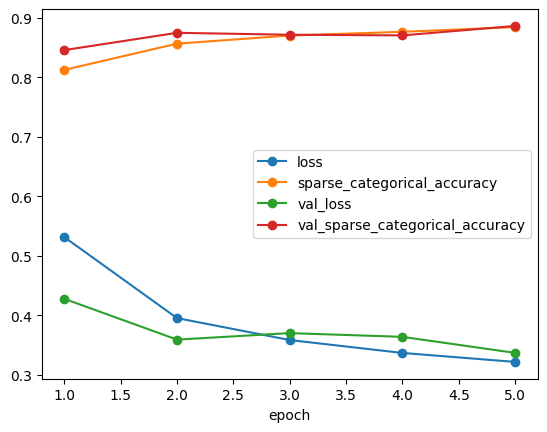

In [109]:
epochs = np.arange(1, 6)
for k, v in hist.items():
    plt.plot(epochs, v, 'o-', label= k)

plt.legend()
plt.xlabel('epoch')
plt.show()

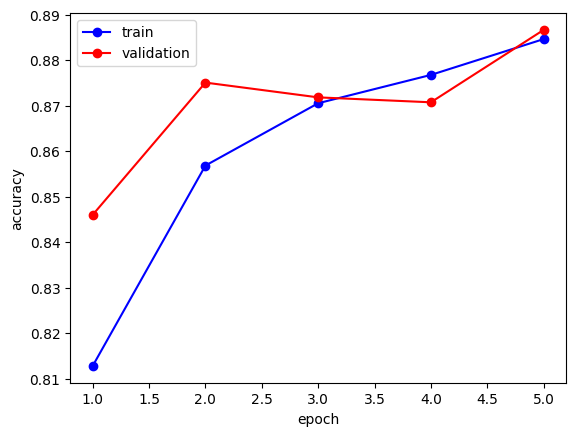

In [110]:
# 정확도
plt.plot(epochs, hist['sparse_categorical_accuracy'], 'bo-', label= 'train')
plt.plot(epochs, hist['val_sparse_categorical_accuracy'], 'ro-', label= 'validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

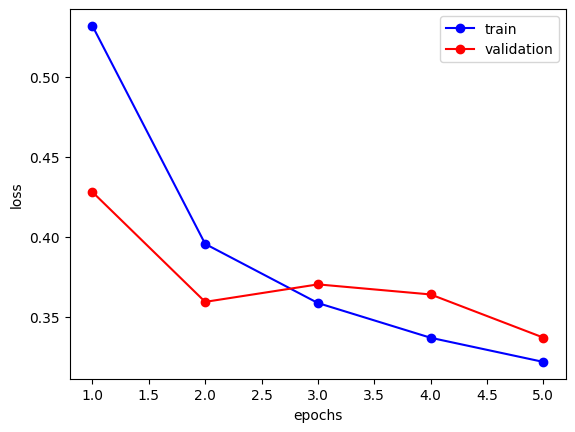

In [111]:
# 손실 그래프
plt.plot(epochs, hist['loss'], 'bo-', label= 'train')
plt.plot(epochs, hist['val_loss'], 'ro-', label= 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## RMSprop 옵티마이저를 사용

*   100개의 unit으로 이루어진 은닉층 1개를 갖는 신경망 모델 생성
*   Rmsprop 옵티 마이저를 사용하도록 모델을 컴파일
*   epoch 횟수를 20회로 모댈을 훈련시키고 그 결과를 저장.
*   History 객체의 history 속성을 사용해서 훈련 셋과 검증 셋의 손실 그래프 그려보기

In [112]:
model = create_model()          # 은닉층 1개를 갖는 모델을 생성
model.compile(optimizer= keras.optimizers.RMSprop(),
              loss= keras.losses.sparse_categorical_crossentropy,
              metrics= [keras.metrics.sparse_categorical_accuracy])

In [113]:
result = model.fit(x= train_data_scaled, y= train_target, epochs= 20,
                   validation_data= [val_data_scaled, val_target])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.6877 - sparse_categorical_accuracy: 0.7619 - val_loss: 0.4128 - val_sparse_categorical_accuracy: 0.8532
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4034 - sparse_categorical_accuracy: 0.8545 - val_loss: 0.4038 - val_sparse_categorical_accuracy: 0.8570
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3594 - sparse_categorical_accuracy: 0.8700 - val_loss: 0.3474 - val_sparse_categorical_accuracy: 0.8762
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3373 - sparse_categorical_accuracy: 0.8788 - val_loss: 0.3708 - val_sparse_categorical_accuracy: 0.8743
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3237 - sparse_categorical_accuracy: 0.8839 - val_loss: 0.3335 - val_sparse_categorical_accuracy: 0.8852
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3118 - sparse_categorical_accuracy: 0.8883 - val_loss: 0.3386 - val_sparse_categorical_accuracy

In [114]:
hist =  result.history
epochs = range(1, len(hist['loss'])+ 1)

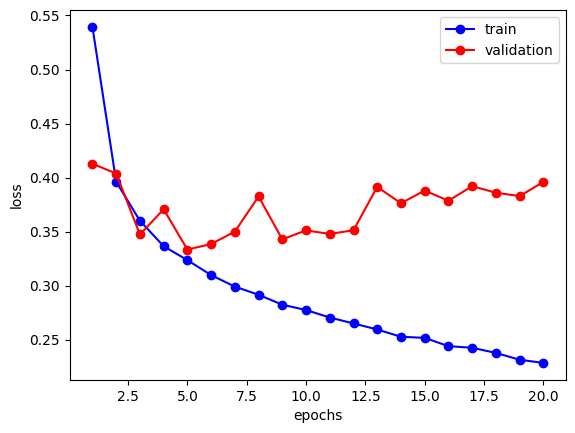

In [115]:
# 손실 그래프
plt.plot(epochs, hist['loss'], 'bo-', label= 'train')
plt.plot(epochs, hist['val_loss'], 'ro-', label= 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Adam 옵티마이저를 사용똑같은 과정

In [116]:
model = create_model()          # 은닉층 1개를 갖는 모델을 생성
model.compile(optimizer= keras.optimizers.Adam(),
              loss= keras.losses.sparse_categorical_crossentropy,
              metrics= [keras.metrics.sparse_categorical_accuracy])

In [117]:
result = model.fit(x= train_data_scaled, y= train_target, epochs= 20,
                   validation_data= [val_data_scaled, val_target])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6780 - sparse_categorical_accuracy: 0.7637 - val_loss: 0.4109 - val_sparse_categorical_accuracy: 0.8558
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4144 - sparse_categorical_accuracy: 0.8549 - val_loss: 0.3574 - val_sparse_categorical_accuracy: 0.8728
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3541 - sparse_categorical_accuracy: 0.8715 - val_loss: 0.3426 - val_sparse_categorical_accuracy: 0.8785
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3274 - sparse_categorical_accuracy: 0.8787 - val_loss: 0.3411 - val_sparse_categorical_accuracy: 0.8776
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3054 - sparse_categorical_accuracy: 0.8890 - val_loss: 0.3213 - val_sparse_categorical_accuracy: 0.8859
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.2853 - sparse_categorical_accuracy: 0.8945 - val_loss: 0.3242 - val_sparse_categorical_accuracy:

In [118]:
hist =  result.history


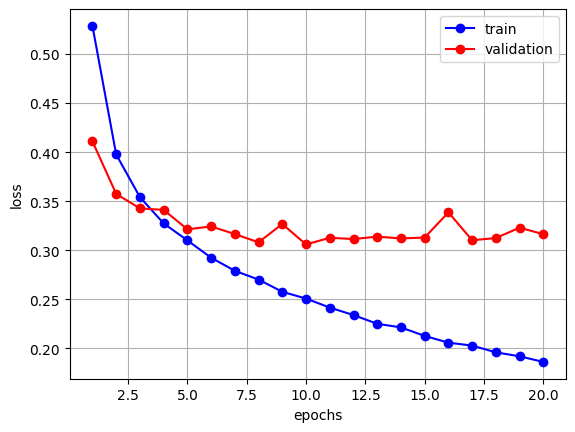

In [119]:
# 손실 그래프
plt.plot(epochs, hist['loss'], 'bo-', label= 'train')
plt.plot(epochs, hist['val_loss'], 'ro-', label= 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()


# Dropout

*   훈련 과정(epoch)에서 일부 unit의 출력을 9으로 만드는 것(그 다음 layer로 출력값을 전달하지 않음).
*   각 epoch마다 출력을 0으로 만드는 unit은 무작위로 선택.
*   모델의 과대적합을 줄일 수 있음.

In [120]:
model = create_model(layers= [keras.layers.Dropout(rate= 0.3)])
# 은닉층 뒤에 30%의 비율로 출력을 0으로 만드는 Dropout 계층을 추가

In [121]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss= keras.losses.sparse_categorical_crossentropy,
              metrics = [keras.metrics.sparse_categorical_accuracy])

In [123]:
result = model.fit(x = train_data_scaled, y= train_target, epochs= 20,
                   validation_data = [val_data_scaled, val_target])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7908 - sparse_categorical_accuracy: 0.7250 - val_loss: 0.4154 - val_sparse_categorical_accuracy: 0.8513
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4499 - sparse_categorical_accuracy: 0.8381 - val_loss: 0.3804 - val_sparse_categorical_accuracy: 0.8620
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4210 - sparse_categorical_accuracy: 0.8439 - val_loss: 0.3753 - val_sparse_categorical_accuracy: 0.8640
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3962 - sparse_categorical_accuracy: 0.8561 - val_loss: 0.3541 - val_sparse_categorical_accuracy: 0.8727
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3769 - sparse_categorical_accuracy: 0.8581 - val_loss: 0.3364 - val_sparse_categorical_accuracy: 0.8776
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3636 - sparse_categorical_accuracy: 0.8650 - val_loss: 0.3375 - val_sparse_categorical_accuracy:

In [166]:
def plot_train_val_losses(history):
    plt.plot(history.epoch, history.history['loss'], 'bo-', label='train')
    plt.plot(history.epoch, history.history['val_loss'], 'ro:', label='validation')
    plt.grid()
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [165]:
plot_train_val_losses(result)

# 모델 저장과 복원

In [125]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,532 (931.77 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 159,022 (621.18 KB)

In [126]:
len(model.weights)

4

In [127]:
model.weights[0]            #> 첫번째 은닉층에서 학습된 모델 파라미터들. (784, 100) shape.

<Variable path=sequential_8/dense_15/kernel, shape=(784, 100), dtype=float32, value=[[ 0.12383327  0.00482869  0.04776201 ...  0.19807631  0.392596
  -0.02930012]
 [-0.42155886 -0.25409567 -0.04842918 ...  0.3304888   0.7616956
   0.04305131]
 [-0.19568984  0.06554246 -0.1522654  ...  1.0585082   0.4379775
   0.09185871]
 ...
 [-0.4091906  -0.17617019  0.11662129 ... -0.12839703 -0.34151182
   0.31211   ]
 [-0.14070542  0.04749846  0.13787554 ... -0.2609777   0.01720846
   0.18430273]
 [-0.26578036 -0.02490374  0.02840272 ... -0.09581386  0.28211623
   0.09089278]]>

In [128]:
model.weights[1]            #>? (100,) shape. 첫번째 은닉층에서 학습된 bias들.

<Variable path=sequential_8/dense_15/bias, shape=(100,), dtype=float32, value=[ 0.44174036  0.14040402 -0.00722369 -0.45589912 -0.5306322   0.02220208
  0.6312544   0.2529496   0.5800844  -0.17992783  0.19331785  0.05168684
  0.29422358 -0.0316286  -0.00992932  0.5818691   0.08063652  0.5330606
  0.34841973 -0.01690417  0.5181669   0.44023368  0.3668749  -0.02343654
  0.7286519   0.08866861 -0.01780206  0.39860252  0.09983545  0.34084085
  0.16252789 -0.40371007  0.44077027 -0.01813618  0.0419375   0.6994587
  0.55172306 -0.01243983  0.43935585  0.12613295  0.04700052 -0.01127628
  0.38510448  0.9023628   0.09596539  0.62762713  0.64607644 -0.01536152
 -0.03595348 -0.01391566 -0.33276588 -0.01318361 -0.01902133 -0.00765271
  0.4402098  -0.2727647  -0.36391822  0.2065325   0.69051945 -0.8326184
 -0.1819423   0.1532581   0.25313076  0.6074892   0.9980952   0.6948304
  0.56988484  0.06889895  0.15463515 -0.01938206 -0.22969484  0.22604139
 -0.35895827 -0.05477422  0.7284483   0.4211486   

In [129]:
model.weights[2]            #> (100, 10) shape.

<Variable path=sequential_8/dense_16/kernel, shape=(100, 10), dtype=float32, value=[[ 9.64780599e-02 -6.73625648e-01 -3.42300951e-01  1.68414578e-01
   3.44457813e-02  4.85762239e-01  2.80245423e-01 -8.88519406e-01
  -3.05915952e-01 -1.02921855e+00]
 [-1.18266977e-01 -2.09460229e-01 -5.10806262e-01 -2.05861077e-01
  -1.52683124e-01  1.93525240e-01  5.18328190e-01 -4.09578055e-01
  -2.00498343e-01  2.43772268e-01]
 [-3.85916114e-01  3.34135056e-01 -3.33475202e-01  4.11593430e-02
   1.17869563e-01  3.55154097e-01 -2.58357763e-01 -5.70158303e-01
  -5.10966957e-01 -1.12304449e+00]
 [-5.65320663e-02  1.69752166e-01 -1.01229243e-01 -6.24692082e-01
   1.69948786e-01  8.85501504e-02 -1.25921100e-01 -3.75839084e-01
  -4.93516892e-01  2.27719158e-01]
 [-1.42081574e-01  2.87409186e-01  7.49985576e-02 -1.80580407e-01
  -1.66816443e-01 -3.13018352e-01  1.01219900e-01 -1.74601525e-02
   1.65251955e-01  1.42954485e-02]
 [ 2.93015718e-01 -2.90332019e-01 -6.97482824e-01 -2.19906449e-01
   2.75019966e-0

In [130]:
model.weights[3]            #> (10, ) shape. 출력층에서 학습된 bias들.

<Variable path=sequential_8/dense_16/bias, shape=(10,), dtype=float32, value=[ 0.00733079 -0.5785215   0.13966684  0.38836944 -0.13860331 -0.3308515
  0.14214416  0.38825545 -0.05165578 -0.7451752 ]>

## 모델 저장

In [131]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [140]:
path = '/content/drive/MyDrive/Colab Notebooks/lab_da'

# 모델 파라미터들만 저장하는 파일의 확장자는 '.weights.h5'
weights_file = path + '/model1.weights.h5'

# 훈련이 끝난 모델을 저장하는 파일의 확장자는 '.keras'
model_file = path + '/model1.keras'

In [141]:
# 모델 파라미터들만 저장
model.save_weights(weights_file)

In [134]:
# 모델의 구조와 모델 파라미터들을 함께 저장
model.save(model_file)

## 파일에 저장된 모델을 복원

### 모델 파라미터들만 저장한 파일 (weight.h5)에서 복원

In [148]:
# 모델 파라미터와 같은 구조로 모델을 먼저 생성.
model = create_model(layers=[keras.layers.Dropout(rate=0.3)])

In [149]:
# 생성된 모델에서 load_weights 메서드 호출, 아규먼트는 저장된 가중치 파일.
model.load_weights(weights_file)

모델 파라미터들만 복원한 경우에는 모델이 컴파일되어 있지 않은 상태이기 때문에 evaluate() 메서드를 호출할 수 없음. 모델 파라미터(가중치)들은 모두 복원이 됐기 때문에 `predict()` 메서드는 호출 가능.

In [150]:
predicts = model.predict(x= train_data_scaled)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [151]:
predict_labels = predicts.argmax(axis= 1)

In [152]:
accuracy_score(train_target, predict_labels)

0.147875

### 모델 구조와 파라미터들을 저장한 파일(keras)에서 모델을 복원

In [153]:
# keras.models.load_model() 함수 호출, 모델을 저장한 파일(.keras)을 아규먼트로 줌.
model = keras.models.load_model(model_file, compile= True)

확장자가 .keras인 파일에서 모델을 복우너하는 경우는 컴파일이 끝난 모델을 복원함. `evaluate()`메서드와 `predict()` 메서드들을 모두 사용할 수 있음.

In [155]:
model.evaluate(x=train_data_scaled, y= train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2189 - sparse_categorical_accuracy: 0.9158


[0.22118449211120605, 0.9152083396911621]

*   callback(콜백): 훈련 과정 중간에 어떤 작업을 수행할 수 있게 만드는 객체. `keras.callback` 모듈 아래의 클래스들을 사용할 수 있음.
*   `keras.callbacks.ModelCheckpoint` 클래스
    *   epoch마다 모델을 저장할 수 있는 기능을 가지고 있는 클래스.
    *   `save_best_only` 파라미터를 True로 설정해서 가장 검증 손실이 작은 모델만을 저장할 수 있음.
*   `keras.callbacks.EarlyStopping` 클래스
    *   과대적합이 시작되기 전에 훈련을 일찍 종료시킬 수 있는 기능을 가지고 있는 클래스.
    *   `fit()`에서 설정된 epochs 횟수보다 일찍 모델 훈련이 종료될 수 있음.


In [156]:
# 모델 생성
model = create_model(layers=[keras.layers.Dropout(rate= 0.3)])

In [159]:
# 모델 컴파일
model.compile(optimizer =  keras.optimizers.Adam(),
              loss= keras.losses.sparse_categorical_crossentropy,
              metrics = [keras.metrics.sparse_categorical_accuracy])

In [160]:
# 모델체크포인트 콜백 객체 생성
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath= path + '/best_model.keras',
                                                save_best_only= True)

In [161]:
# 조기종료 콜백 객체 생성
early_stop_cb= keras.callbacks.EarlyStopping(patience= 3,
                                             restore_best_weights= True)           # patience 인내심 손실이 늘어가더라고 3번정도는 늘어나는것을 기다리겠다.

In [163]:
# 검증 셋과 콜백들을 설정해서 모델을 훈련
model.fit(x= train_data_scaled, y= train_target, epochs= 100,
          callbacks= [checkpoint_cb, early_stop_cb],
          validation_data=[val_data_scaled, val_target])

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.7599 - sparse_categorical_accuracy: 0.7348 - val_loss: 0.4227 - val_sparse_categorical_accuracy: 0.8501
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4609 - sparse_categorical_accuracy: 0.8359 - val_loss: 0.3744 - val_sparse_categorical_accuracy: 0.8663
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4129 - sparse_categorical_accuracy: 0.8488 - val_loss: 0.3624 - val_sparse_categorical_accuracy: 0.8698
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3845 - sparse_categorical_accuracy: 0.8568 - val_loss: 0.3510 - val_sparse_categorical_accuracy: 0.8724
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3685 - sparse_categorical_accuracy: 0.8654 - val_loss: 0.3460 - val_sparse_categorical_accuracy: 0.8755
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3553 - sparse_categorical_accuracy: 0.8688 - val_loss: 0.3295 - val_sparse_categorical_acc

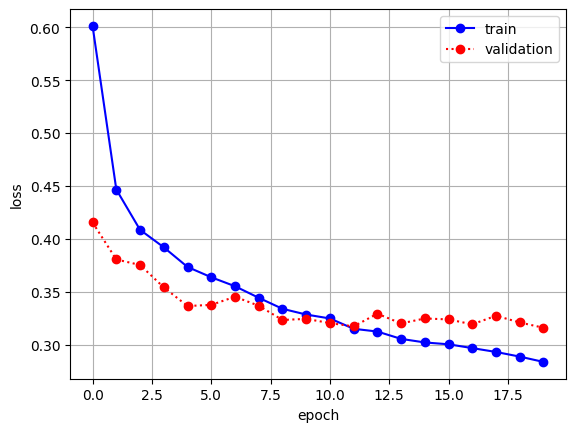

In [169]:
plot_train_val_losses(result)

In [170]:
# 훈련이 끝난 모델 평가
model.evaluate(x= train_data_scaled, y= train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2282 - sparse_categorical_accuracy: 0.9132


[0.23206757009029388, 0.9126666784286499]

In [171]:
model.evaluate(x= val_data_scaled, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3105 - sparse_categorical_accuracy: 0.8857


[0.3103015124797821, 0.8891666531562805]

In [172]:
# 최적의 파라미터들과 모델 구조를 저장할 파일에서 모델을 복원
best_model= keras.models.load_model(filepath= path + '/best_model.keras')

In [173]:
best_model.evaluate(x= train_data_scaled, y= train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2282 - sparse_categorical_accuracy: 0.9132


[0.23206757009029388, 0.9126666784286499]

In [176]:
best_model.evaluate(x= val_data_scaled, y= val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3105 - sparse_categorical_accuracy: 0.8857


[0.3103015124797821, 0.8891666531562805]